In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.10.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.10.2 on the current Colab Runtime...
2024-04-11 19:47:55 URL:https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.2-linux-x86_64.tar.gz [169654402/169654402] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.10

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [1]:
versioninfo()

Julia Version 1.10.2
Commit bd47eca2c8 (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Windows (x86_64-w64-mingw32)
  CPU: 6 × AMD Ryzen 5 4500U with Radeon Graphics         
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-15.0.7 (ORCJIT, znver2)
Threads: 1 default, 0 interactive, 1 GC (on 6 virtual cores)
Environment:
  JULIA_NUM_THREADS = 


In [1]:
import Pkg
Pkg.add("SDDP")
Pkg.add("HiGHS")
Pkg.add("Plots")

    Updating registry at `C:\Users\matsz\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\matsz\.julia\environments\v1.10\Manifest.toml`


In [2]:
using SDDP, HiGHS, Statistics, DataFrames, Plots, CSV

In [3]:
exp.([-0.14, 0.06, 0.26])

3-element Vector{Float64}:
 0.8693582353988059
 1.0618365465453596
 1.2969300866657718

In [93]:
function asset_management_simple()

    
    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],                                             
            ],
        ),
        lower_bound = -1_800.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.867, 1.06, 1.297]
        r_bonds = [1.03]
        consumption = 5
        goal = 50

        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)

        
        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + consumption == 55)
            @stageobjective(subproblem, 0)
        elseif 1 < stage < 6
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in +
                r_bonds[1] * bonds.in == stocks.out + bonds.out + consumption
            )
            @stageobjective(subproblem, 0)
        else
            @variable(subproblem, over >= 0)
            @variable(subproblem, short >= 0)
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in +
                r_bonds[1] * bonds.in - over + short + consumption == goal
            )
            @stageobjective(subproblem, -over + 4 * short)
        end
    end
    SDDP.train(model;log_frequency = 5)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_simple()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 16
  state variables : 2
  scenarios       : 2.43000e+02
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [5, 7]
  AffExpr in MOI.EqualTo{Float64}         : [1, 1]
  VariableRef in MOI.GreaterThan{Float64} : [3, 5]
  VariableRef in MOI.LessThan{Float64}    : [1, 1]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 4e+00]
  bounds range     [2e+03, 2e+03]
  rhs range        [5e+00, 5e+01]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
----------------------------------------------

A policy graph with 16 nodes.
 Node indices: (1, 1), ..., (6, 3)


In [18]:
function asset_management_merton_deterministic()
    
    #goal = 65
    #-(consumption^-1-1)/-1

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],                                
            ],
        ),
        lower_bound = -200.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock_deterministic = [1, 1.06, 0.866, 1.254,1.06,1.06]
        r_bonds = [1.03]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)
       # @variable(subproblem, consumption >= 0)

        minimum_limit = 0
        acceptable_limit = 20
        desired_limit = 25

        @variable(subproblem, 0 <= acceptable <= acceptable_limit)
        @variable(subproblem, 0 <= desired <= desired_limit - acceptable_limit)
        @variable(subproblem, 0 <= above_desired)
       # @constraint(subproblem, acceptable + desired + above_desired == consumption)

        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + acceptable + desired + above_desired == 100)            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        elseif 1 < stage #< 6
            @constraint(
                subproblem,
                r_stock_deterministic[stage] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + acceptable + desired + above_desired
            )            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
      #=   else
            @constraint(
                subproblem,
                r_stock_deterministic[stage] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + acceptable + desired + above_desired
            )            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired)) =#
        end 
    end
    SDDP.train(model; log_frequency = 5)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_merton_deterministic()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 16
  state variables : 2
  scenarios       : 2.43000e+02
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [8, 8]
  AffExpr in MOI.EqualTo{Float64}         : [1, 1]
  VariableRef in MOI.GreaterThan{Float64} : [6, 6]
  VariableRef in MOI.LessThan{Float64}    : [2, 3]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 3e+00]
  bounds range     [5e+00, 2e+02]
  rhs range        [1e+02, 1e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
----------------------------------------------

A policy graph with 16 nodes.
 Node indices: (1, 1), ..., (6, 3)


In [153]:
function asset_management_merton()

    
    #goal = 65
    #-(consumption^-1-1)/-1

    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
            ]            
        ),
        lower_bound = -370.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.866, 1.06, 1.254]
        r_bonds = [1.04]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)


        #@variable(subproblem, consumption >= 0)

        minimum_limit = 0
        acceptable_limit = 15
        desired_limit = 18

        minimum = 5
  
        @variable(subproblem, minimum_limit <= acceptable <= acceptable_limit)
        @variable(subproblem, 0 <= desired <= desired_limit - acceptable_limit)
        @variable(subproblem, 0 <= above_desired)
        @variable(subproblem, consumption >=0)
        @constraint(subproblem, acceptable + desired + above_desired == consumption)
       

        #@constraint(subproblem, acceptable + desired + above_desired == consumption)
        
        if stage == 1
            @constraint(subproblem, stocks.out + bonds.out + consumption == 100)            
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired))
        elseif 1 < stage 
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in + r_bonds[1] * bonds.in == stocks.out + bonds.out + consumption)
            @stageobjective(subproblem, -(3*acceptable + 2*desired + above_desired ))
        end
    end
    SDDP.train(model; iteration_limit =1000, log_frequency = 100)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_merton()

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 25
  state variables : 2
  scenarios       : 6.56100e+03
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [9, 9]
  AffExpr in MOI.EqualTo{Float64}         : [2, 2]
  VariableRef in MOI.GreaterThan{Float64} : [7, 7]
  VariableRef in MOI.LessThan{Float64}    : [2, 3]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e+00, 3e+00]
  bounds range     [3e+00, 4e+02]
  rhs range        [1e+02, 1e+02]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
----------------------------------------------

A policy graph with 25 nodes.
 Node indices: (1, 1), ..., (9, 3)


In [6]:
module Temp
    struct GoalsData3
        minimum_limit:: Vector{Int64}
        acceptable_limit:: Vector{Int64}
        desired_limit::Vector{Int64}
        inflows:: Vector{Int64}
        minimum_utility:: Int64
        acceptable_utility:: Int64
        desired_utility:: Int64
        above_desired_utility:: Float32
        initial_wealth:: Int64
        provision:: Float32
    end
end

Main.Temp

In [142]:
data = CSV.read("./goal_data.csv", DataFrame, decimal=',')

Row,t,minimum_limit,acceptable_limit,desired_limit,inflows,minimum_utility,acceptable_utility,desired_utility,above_desired_utility:
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64
1,1,0,0,0,0,20,10,5,0.01
2,2,0,0,0,6,20,10,5,0.01
3,3,0,0,0,6,20,10,5,0.01
4,4,0,0,0,6,20,10,5,0.01
5,5,0,0,0,6,20,10,5,0.01
6,6,0,0,0,6,20,10,5,0.01
7,7,0,0,0,6,20,10,5,0.01
8,8,0,0,0,6,20,10,5,0.01
9,9,0,0,0,6,20,10,5,0.01


In [159]:
model_data = Temp.GoalsData3(
    data.minimum_limit,
    data.acceptable_limit,
    data.desired_limit,
    data.inflows,
    4,
    3,
    2,
    0.1,
    50,
    0.0029
    )


Main.Temp.GoalsData3([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 110], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 134], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 155], [0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], 4, 3, 2, 0.1f0, 50, 0.0029f0)

In [160]:
function asset_management_alm(data:: Temp.GoalsData3)
  
    model = SDDP.PolicyGraph(
        SDDP.MarkovianGraph(
            Array{Float64,2}[
                [1.0]',
                [0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28], 
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],   
                [0.28 0.44 0.28; 0.28 0.44 0.28; 0.28 0.44 0.28],  
            ]            
        ),
        lower_bound = -556.0,
        optimizer = HiGHS.Optimizer,
    ) do subproblem, index
        (stage, markov_state) = index
        r_stock = [0.867, 1.06, 1.297]
        r_bonds = [1.03]
        @variable(subproblem, stocks >= 0, SDDP.State, initial_value = 0.0)
        @variable(subproblem, bonds >= 0, SDDP.State, initial_value = 0.0)

        @variable(subproblem, bonds_buy >= 0)
        @variable(subproblem, bonds_sell >= 0)
        @variable(subproblem, stocks_buy >= 0)
        @variable(subproblem, stocks_sell >= 0)                     
         
        
        @variable(subproblem, consumption >=0)
        
        @variable(subproblem, 0 <= minimum<= data.minimum_limit[stage])
        @variable(subproblem, 0 <= acceptable <= data.acceptable_limit[stage] - data.minimum_limit[stage])
        @variable(subproblem, 0 <= desired <= data.desired_limit[stage] - data.acceptable_limit[stage])
        @variable(subproblem, 0 <= above_desired)
        @constraint(subproblem, minimum + acceptable + desired + above_desired == consumption)
                     
        if stage == 1
            @constraint(subproblem, bonds_buy - bonds_sell == bonds.out)
            @constraint(subproblem, stocks_buy - stocks_sell == stocks.out)
            @constraint(subproblem, stocks_buy*(1+data.provision) + bonds_buy*(1+data.provision) + consumption == data.initial_wealth) 
                                           
            @stageobjective(subproblem, -(data.minimum_utility * minimum + data.acceptable_utility * acceptable + data.desired_utility * desired + data.above_desired_utility * above_desired))
            
        elseif 1 < stage 
            @constraint(
                subproblem,
                r_stock[markov_state] * stocks.in + stocks_buy - stocks_sell== stocks.out)

            @constraint(
                subproblem,
                r_bonds[1] * bonds.in + bonds_buy - bonds_sell== bonds.out)

            @constraint(subproblem, stocks_buy*(1+data.provision) - stocks_sell*(1+data.provision) + bonds_buy*(1+data.provision) - bonds_sell*(1+data.provision) + consumption - data.inflows[stage] == 0) 

            @stageobjective(subproblem, -(data.minimum_utility * minimum + data.acceptable_utility * acceptable + data.desired_utility * desired + data.above_desired_utility * above_desired))
        end
    end
    SDDP.train(model; iteration_limit = 1500, log_frequency = 10)
   #@test SDDP.calculate_bound(model) ≈ 1.514 atol = 1e-4
    return model
end

model = asset_management_alm(model_data)

#replication = 23
#stage =4
#simulations[replication][stage]

-------------------------------------------------------------------
         SDDP.jl (c) Oscar Dowson and contributors, 2017-23
-------------------------------------------------------------------
problem
  nodes           : 31
  state variables : 2
  scenarios       : 5.90490e+04
  existing cuts   : false
options
  solver          : serial mode
  risk measure    : SDDP.Expectation()
  sampling scheme : SDDP.InSampleMonteCarlo
subproblem structure
  VariableRef                             : [14, 14]
  AffExpr in MOI.EqualTo{Float64}         : [4, 4]
  VariableRef in MOI.GreaterThan{Float64} : [12, 12]
  VariableRef in MOI.LessThan{Float64}    : [3, 4]
numerical stability report
  matrix range     [9e-01, 1e+00]
  objective range  [1e-01, 4e+00]
  bounds range     [2e+01, 6e+02]
  rhs range        [6e+00, 5e+01]
-------------------------------------------------------------------
 iteration    simulation      bound        time (s)     solves  pid
------------------------------------------

A policy graph with 31 nodes.
 Node indices: (1, 1), ..., (11, 3)


In [161]:
simulations = SDDP.simulate(
    # The trained model to simulate.
    model,
    # The number of replications.
    1000,
    # A list of names to record the values of.
    [:stocks, :bonds, :minimum, :acceptable, :desired, :above_desired, :consumption],
    skip_undefined_variables=true
)

println("Lower bounds", SDDP.calculate_bound(model))

objectives = map(simulations) do simulation
    return sum(stage[:stage_objective] for stage in simulation)
end

μ, ci = SDDP.confidence_interval(objectives)
println("Confidence interval: ", μ, " ± ", ci)

Lower bounds-539.0909441509973
Confidence interval: -541.7110163367995 ± 2.288333020546083


In [146]:
plt = SDDP.SpaghettiPlot(simulations)

SDDP.add_spaghetti(plt; title = "Stocks") do data
    return data[:stocks].out
end

SDDP.plot(plt)


In [147]:
plt = SDDP.SpaghettiPlot(simulations)

SDDP.add_spaghetti(plt; title = "Consumption") do data
    return data[:acceptable] + data[:desired] + data[:above_desired]
end

SDDP.plot(plt)

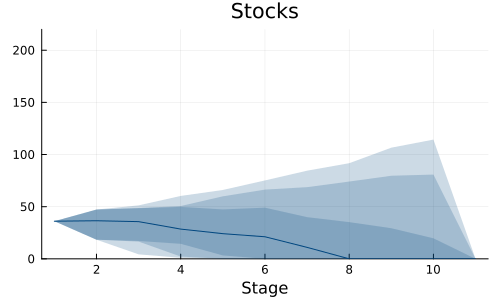

In [162]:
import Plots

Plots.plot(
    SDDP.publication_plot(simulations, title = "Stocks") do data
        return data[:stocks].out
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 220),
    layout = (1, 2),
)

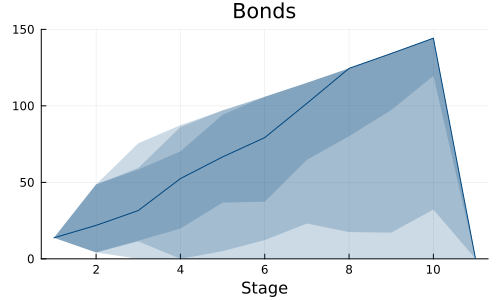

In [163]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Bonds") do data
        return data[:bonds].out
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 150),
    layout = (1, 2),
)

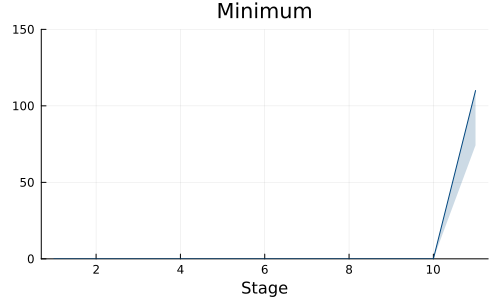

In [164]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Minimum") do data
        return data[:minimum]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 150),
    layout = (1, 2),
)

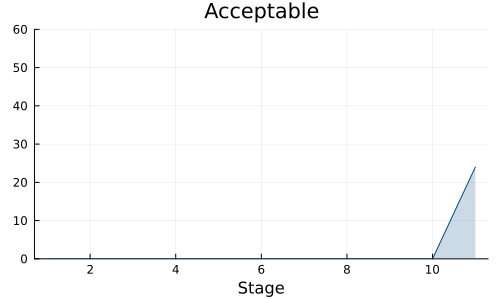

In [165]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Acceptable") do data
        return data[:acceptable]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 60),
    layout = (1, 2),
)

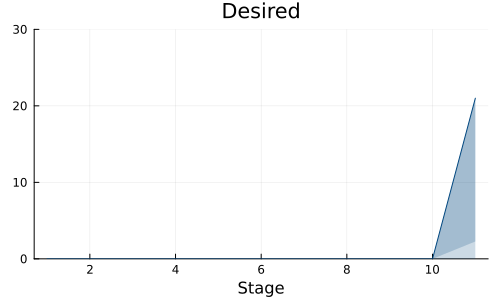

In [166]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Desired") do data
        return data[:desired]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 30),
    layout = (1, 2),
)

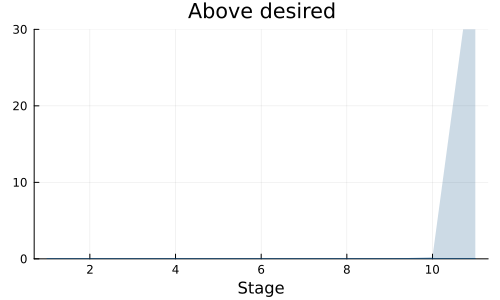

In [167]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Above desired") do data
        return data[:above_desired]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 30),
    layout = (1, 2),
)

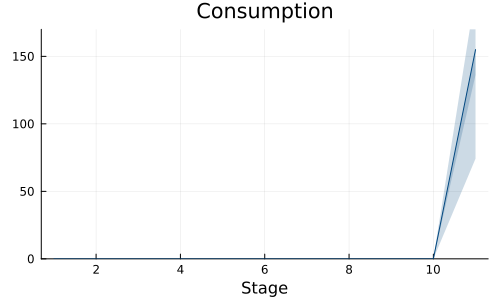

In [168]:
Plots.plot(
    SDDP.publication_plot(simulations, title = "Consumption") do data
        return data[:consumption]
    end,
  #  SDDP.publication_plot(simulations, title = "Bonds") do data
  #      return data[:bonds]
  #  end;
    xlabel = "Stage",
    ylims = (0, 170),
    layout = (1, 2),
)

In [169]:
n_scenarios = 1000
n_stages = 11

bonds = zeros(n_scenarios,n_stages)
stocks = zeros(1000,n_stages)
consumption = zeros(1000,n_stages)

for (i, scenario) in enumerate(simulations)
    bonds[i,:] = [node[:bonds].out for node in scenario]
    stocks[i,:] = [node[:stocks].out for node in scenario]
    consumption[i,:] = [node[:consumption] for node in scenario]
end

bonds_perc = zeros(5,n_stages)

for t in 1:n_stages
    bonds_perc[:,t] = quantile(bonds[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

bonds_perc

5×11 Matrix{Float64}:
 13.7673   4.18144   0.0      0.0     …    0.0       0.0       0.0    0.0
 13.7673   4.18144  11.8674  19.8159      80.1734   97.2664  119.583  0.0
 13.7673  21.886    31.5737  52.476      124.512   134.232   144.242  0.0
 13.7673  48.6392   58.3986  70.2717     124.514   134.232   144.242  0.0
 13.7673  48.6392   75.5489  87.3717     124.514   134.232   144.242  0.0

In [170]:
stocks_perc = zeros(5,n_stages)

for t in 1:n_stages
    stocks_perc[:,t] = quantile(stocks[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

stocks_perc 

5×11 Matrix{Float64}:
 36.0881  18.3301   4.30625   1.19799  …  -8.82873e-9   -1.42613e-8   0.0
 36.0881  18.3301  17.1123   14.3894      -7.92308e-13  -2.08484e-11  0.0
 36.0881  36.5304  35.6737   28.5217       1.88755e-9    8.10328e-11  0.0
 36.0881  47.2699  48.5282   49.8301      29.3561       19.6945       0.0
 36.0881  47.2699  51.2726   60.2801      90.6498       99.0307       0.0

In [171]:
mean(stocks,dims=1)

1×11 Matrix{Float64}:
 36.0881  34.1696  31.9363  29.4655  …  21.7043  19.2431  17.349  0.0

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,49.8554,51.4514,51.2726,60.0373,69.2418,67.7702,77.819,87.7124,96.8667,108.661,0.0
2,49.8554,51.4514,60.3957,69.646,82.0268,91.8277,104.717,115.386,126.622,139.877,0.0
3,49.8554,58.4164,67.2474,80.9977,90.7675,100.431,112.889,124.514,134.232,144.242,0.0
4,49.8554,66.9693,75.5109,84.6611,96.6295,105.919,115.079,124.514,134.232,144.242,0.0
5,49.8554,66.9693,79.8551,88.5807,97.2607,106.201,115.08,124.514,134.232,144.242,0.0


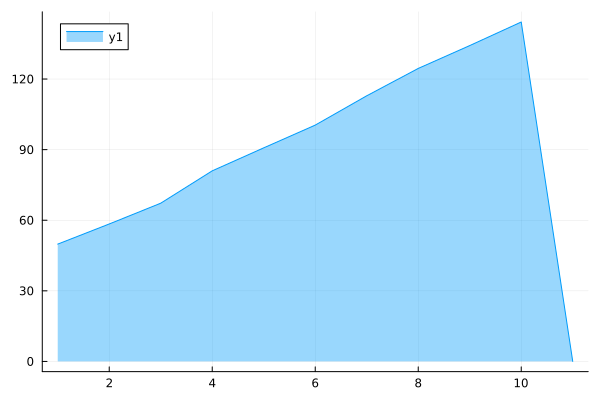

In [172]:
wealth = stocks .+ bonds

wealth_perc = zeros(5,n_stages)

for t in 1:n_stages
    wealth_perc[:,t] = quantile(wealth[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end


display(DataFrame(wealth_perc, :auto))

areaplot(wealth_perc[3,:], fillalpha=0.4)


Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.723855,0.273709,0.0539258,0.0135243,0.0,-4.87064e-12,-1.7714e-11,-4.95293e-11,-6.57721e-11,-9.88709e-11,0.0
2,0.723855,0.273709,0.22662,0.169965,0.0333724,2.98025e-8,7.79056e-12,0.0,-5.90252e-15,-1.44538e-13,0.0
3,0.723855,0.625344,0.530484,0.35213,0.265972,0.210809,0.0973541,2.38924e-5,1.40618e-11,5.61784e-13,0.0
4,0.723855,0.91873,0.803505,0.715477,0.559331,0.586585,0.381729,0.305174,0.23184,0.140718,0.0
5,0.723855,0.91873,1.0,1.0,0.953777,1.0,1.0,1.0,1.0,1.0,0.0


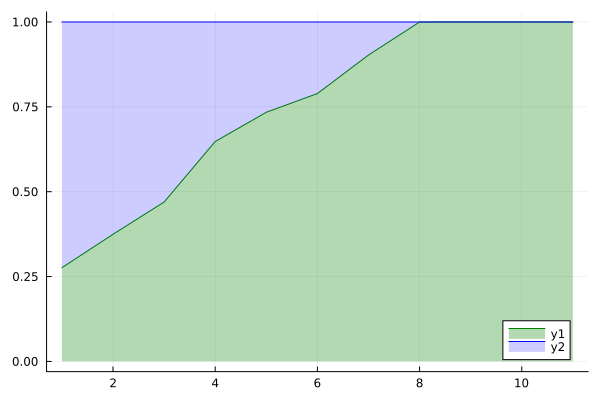

In [173]:
stocks_weight = stocks ./wealth

stocks_weight[:,end] .= 0

stocks_weight_perc = zeros(5,n_stages)

for t in 1:n_stages
    stocks_weight_perc[:,t] = quantile(stocks_weight[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

display(DataFrame(stocks_weight_perc, :auto))

bonds_weight_perc = 1 .- stocks_weight_perc

areaplot(1:11, [bonds_weight_perc[3,1:11] stocks_weight_perc[3,1:11]], seriescolor = [:green :blue], fillalpha = [0.3 0.2])

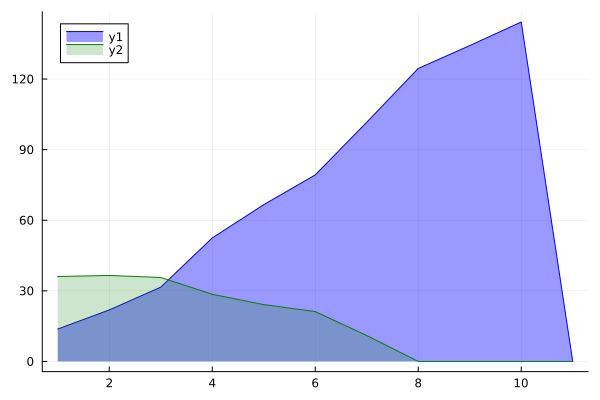

In [174]:
areaplot(1:11,[bonds_perc[3,:], stocks_perc[3,:]], seriescolor=[:blue :green],fillalpha=[0.4 0.2])

In [175]:
consumption_perc = zeros(5,n_stages)

for t in 1:n_stages
    consumption_perc[:,t] = quantile(consumption[:,t], [0.05, 0.25, 0.5, 0.75, 0.95])
end

DataFrame(consumption_perc, :auto) 

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,116.888
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.0


In [203]:
count(c -> (c >= 155.0), consumption[:,11])/n_scenarios

0.527

In [198]:
CSV.write("cons.csv",DataFrame([consumption[:,11]], :auto))

"cons.csv"

In [209]:
minimum_limit = model_data.minimum_limit
acceptable_limit = model_data.acceptable_limit
desired_limit = model_data.desired_limit
limits = [minimum_limit, acceptable_limit, desired_limit]

goals_succes = zeros(n_stages,3)

for goal in 1:3
    goals_succes[:,goal] = [count(c -> (round(c,digits=1) >= limits[goal][t]), consumption[:,t]) /n_scenarios for t in 1:n_stages]
end

DataFrame(goals_succes, [string(minimum_limit[11]),string(acceptable_limit[11]),string(desired_limit[11])])

Row,110,134,155
,Float64,Float64,Float64
1,1.0,1.0,1.0
2,1.0,1.0,1.0
3,1.0,1.0,1.0
4,1.0,1.0,1.0
5,1.0,1.0,1.0
6,1.0,1.0,1.0
7,1.0,1.0,1.0
8,1.0,1.0,1.0
9,1.0,1.0,1.0


In [178]:
total_consumption = sum(consumption,dims=2)

total_consumption_perc = [quantile(total_consumption,[0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95])]


1-element Vector{Vector{Float64}}:
 [116.88833098228014, 136.27144001622702, 154.999999999059, 155.00000000000105, 155.00000000113175, 155.00000003821984, 155.00000007793776]

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />